In [27]:
import os
import sys
import scipy
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from PIL import Image
import numpy as np
import pprint
from utils_vgg import *

In [3]:
model = load_vgg_model("data/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 450, 600, 3) dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
      

### COMPUTING THE CONTENT COST

Let $a^{(G)}$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

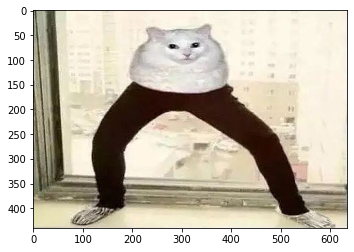

In [5]:
import imageio
img = imageio.imread("images/catto.jpg")
plt.imshow(img)

In [6]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H*n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 7.641023


### COMPUTING THE STYLE COST

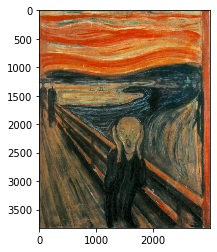

In [9]:
style_img = imageio.imread("images/scream.jpg")
plt.imshow(style_img)

### STYLE MATRIX

In [10]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    A = tf.random_normal([3, 2], mean=1, stddev=4)
    GA = gram_matrix(A)

    print("GA = \n" + str(GA.eval()))

GA = 
[[29.54199    4.198667  34.58755  ]
 [ 4.198667   1.0211201  3.8079093]
 [34.58755    3.8079093 43.38695  ]]


### STYLE COST

The goal is to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, abd the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where  $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

In [19]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])    
    
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)

    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 13.172418


### STYLE WEIGHTS

In [16]:
STYLE_LAYERS = [
                ("conv1_1", 0.2),
                ("conv2_1", 0.2),
                ("conv3_1", 0.2),
                ("conv4_1", 0.2),
                ("conv5_1", 0.2)]

Style cost for different layers:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [17]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        
        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer
        
    return J_style

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [20]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

In [21]:
tf.reset_default_graph()

with tf.Session() as test:
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 32.822037541610825


### SOLVING THE OPTIMIZATION PROBLEM

In [22]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [24]:
img = imageio.imread("images/catto.jpg")
img = reshape_and_normalize_img(img)

In [25]:
style_img = imageio.imread("images/scream.jpg")
style_img = reshape_and_normalize_img(style_img)

In [28]:
generated_img = generate_noise_img(img)
plt.imshow(generated_img[0])

AttributeError: 'tuple' object has no attribute 'astype'